In [1]:
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, KFold
import numpy as np
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.model_selection import cross_val_score
from sklearn.preprocessing import PolynomialFeatures
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.svm import SVR
import seaborn as sns


#hdi data
human_development_index = pd.read_csv("./human-development-index.csv")
#global food price
FAOFP1990_2022 = pd.read_csv("./FAOFP1990_2022.csv")
#first foodprice dataset
wfp_market_food_prices = pd.read_csv("./wfp_market_food_prices.csv", encoding='ISO-8859-1')
#second foodprice dataset, more updated version
global_food_prices = pd.read_csv("./global_food_prices.csv", low_memory = False)
#population data
Edited_api = pd.read_csv("./Edited_api.csv")
#weather data
weatherData = pd.read_csv("weatherData.csv")

In [2]:
#hdi data preprocessing
hdi = human_development_index

countries = ['Central African Republic','Egypt','Algeria','Turkey','Iraq','Indonesia','Nepal','Afghanistan','Cambodia','Colombia','Lebanon']

hdi = hdi[hdi['Entity'].isin(countries)]
hdi = hdi.drop('Code', axis = 1)

In [3]:
#fp data preprocessing
fp = global_food_prices

In [4]:
#filter out useless columns
fp = fp.drop(['adm0_id','adm1_id','mkt_id','cm_id','cur_id','pt_id','um_id','mp_commoditysource'], axis = 1)

#checking of filtered correctly
print(fp.columns)
print(fp)

Index(['adm0_name', 'adm1_name', 'mkt_name', 'cm_name', 'cur_name', 'pt_name',
       'um_name', 'mp_month', 'mp_year', 'mp_price'],
      dtype='object')
           adm0_name   adm1_name    mkt_name                  cm_name  \
0        Afghanistan  Badakhshan    Fayzabad           Bread - Retail   
1        Afghanistan  Badakhshan    Fayzabad           Bread - Retail   
2        Afghanistan  Badakhshan    Fayzabad           Bread - Retail   
3        Afghanistan  Badakhshan    Fayzabad           Bread - Retail   
4        Afghanistan  Badakhshan    Fayzabad           Bread - Retail   
...              ...         ...         ...                      ...   
2050633     Zimbabwe    Midlands  Mbilashaba   Beans (sugar) - Retail   
2050634     Zimbabwe    Midlands  Mbilashaba      Toothpaste - Retail   
2050635     Zimbabwe    Midlands  Mbilashaba    Laundry soap - Retail   
2050636     Zimbabwe    Midlands  Mbilashaba   Handwash soap - Retail   
2050637     Zimbabwe    Midlands  Mbilasha

In [5]:
#filter out unwanted countries
fp = fp[fp['adm0_name'].isin(countries)]
#checking if filtered correctly
print(fp['adm0_name'].value_counts())

Indonesia                   72437
Lebanon                     42784
Colombia                    26540
Iraq                        25578
Cambodia                    21871
Nepal                       18071
Afghanistan                 15427
Central African Republic    12720
Turkey                      10483
Egypt                        2304
Algeria                      1793
Name: adm0_name, dtype: int64


In [6]:
#frequency table for unit of measurement
print(fp['um_name'].value_counts())

KG             200300
L               11837
Unit             4802
Day              4677
20 L             2614
5 L              2444
200 G            2136
160 G            2128
900 G            2124
30 pcs           2115
185 G            1901
1.3 KG           1665
10 pcs           1606
10 KG            1304
USD/LCU          1209
Cylinder          831
125 G             775
MT                713
Dozen             608
Head              550
Gallon            543
Packet            394
Libra             387
4 pcs             306
150 ml            306
Package           228
12 KG             218
kWh               204
Cubic meter       204
385 G             158
Course            151
85 G              108
Month              87
500 ML             82
500 G              80
168 G              68
380 G              68
1.5 L              48
400 G              24
Sack                5
Name: um_name, dtype: int64


In [7]:
#filter out all rows where the measurement isnt in kg
fp = fp[fp['um_name'] == 'KG']

#checking if filtered out correctly
print(fp['um_name'].value_counts())

KG    200300
Name: um_name, dtype: int64


In [8]:
#average out the price for each year, since each month has its own price right now.
fp = fp.groupby(['adm0_name', 'cm_name', 'cur_name', 'mp_year'], as_index=False)['mp_price'].mean()

#checking if table produced correctly
print(fp)

        adm0_name            cm_name cur_name  mp_year   mp_price
0     Afghanistan     Bread - Retail      AFN     2000  17.213750
1     Afghanistan     Bread - Retail      AFN     2001  16.522667
2     Afghanistan     Bread - Retail      AFN     2002  11.587872
3     Afghanistan     Bread - Retail      AFN     2003  13.016667
4     Afghanistan     Bread - Retail      AFN     2004  15.622917
...           ...                ...      ...      ...        ...
1990       Turkey  Zucchini - Retail      TRY     2017   3.477094
1991       Turkey  Zucchini - Retail      TRY     2018   3.656315
1992       Turkey  Zucchini - Retail      TRY     2019   4.288779
1993       Turkey  Zucchini - Retail      TRY     2020   5.100065
1994       Turkey  Zucchini - Retail      TRY     2021   5.812096

[1995 rows x 5 columns]


In [9]:
#frequency table for commodity types
pd.set_option('display.max_rows', None)
fp['cm_name'].value_counts()

Wheat flour - Retail                           109
Rice - Retail                                   64
Sugar - Retail                                  49
Meat (beef) - Retail                            40
Tomatoes - Retail                               31
Lentils - Retail                                28
Beans (white) - Retail                          28
Potatoes - Retail                               26
Garlic - Retail                                 24
Meat (chicken) - Retail                         22
Bread - Retail                                  22
Wheat - Retail                                  22
Salt - Retail                                   22
Maize (yellow) - Wholesale                      22
Maize (white) - Wholesale                       22
Wheat flour - Wholesale                         22
Sugar (white) - Wholesale                       21
Rice (ordinary, second quality) - Wholesale     21
Chickpeas - Retail                              21
Rice (ordinary, first quality) 

In [10]:
#filtering out the rows with the unwanted commodities
commodities = ['Wheat flour - Retail', 'Rice - Retail', 'Sugar - Retail', 'Meat (beef) - Retail', 'Tomatoes - Retail', 'Lentils - Retail', 'Beans (white) - Retail', 'Potatoes - Retail', 'Garlic - Retail']
fp = fp[fp['cm_name'].isin(commodities)]

#checking if filtered out correctly
fp['cm_name'].value_counts()

Wheat flour - Retail      109
Rice - Retail              64
Sugar - Retail             49
Meat (beef) - Retail       40
Tomatoes - Retail          31
Beans (white) - Retail     28
Lentils - Retail           28
Potatoes - Retail          26
Garlic - Retail            24
Name: cm_name, dtype: int64

In [12]:
#second food price data pre-processing
fp2 = wfp_market_food_prices
fp2 = fp2.drop(['adm0_id','adm1_id','mkt_id','cm_id','cur_id','pt_id','um_id','mp_commoditysource'], axis = 1)
fp2 = fp2[fp2['adm0_name'].isin(countries)]
fp2 = fp2[fp2['um_name'] == 'KG']
fp2 = fp2.groupby(['adm0_name', 'cm_name', 'cur_name', 'mp_year'], as_index=False)['mp_price'].mean()
print(fp2)
      
#turns out this dataset is the exact same as the first one, but just more out-dated, so annontation for this block will be skipped.

                    adm0_name                        cm_name cur_name  \
0                 Afghanistan                          Bread      AFN   
1                 Afghanistan                          Bread      AFN   
2                 Afghanistan                          Bread      AFN   
3                 Afghanistan                          Bread      AFN   
4                 Afghanistan             Rice (low quality)      AFN   
5                 Afghanistan             Rice (low quality)      AFN   
6                 Afghanistan             Rice (low quality)      AFN   
7                 Afghanistan             Rice (low quality)      AFN   
8                 Afghanistan             Rice (low quality)      AFN   
9                 Afghanistan             Rice (low quality)      AFN   
10                Afghanistan             Rice (low quality)      AFN   
11                Afghanistan             Rice (low quality)      AFN   
12                Afghanistan             Rice (low

In [13]:
#population data preprocessing
#changing the name for egypt
pdata = Edited_api.copy()
pdata['Country Name'] = pdata['Country Name'].replace("Egypt, Arab Rep.", "Egypt")

#frequency table for country name
pd.set_option('display.max_rows', None)
print(pdata['Country Name'].value_counts())

Aruba                                                   1
Oman                                                    1
Malawi                                                  1
Malaysia                                                1
North America                                           1
Namibia                                                 1
New Caledonia                                           1
Niger                                                   1
Nigeria                                                 1
Nicaragua                                               1
Netherlands                                             1
Norway                                                  1
Nepal                                                   1
Nauru                                                   1
New Zealand                                             1
OECD members                                            1
Other small states                                      1
French Polynes

In [14]:
#filtering out unwanted countries
pdata = pdata[pdata['Country Name'].isin(countries)]
#checking if filtered out correctly
print(pdata['Country Name'].value_counts())

Afghanistan                 1
Central African Republic    1
Colombia                    1
Algeria                     1
Egypt                       1
Indonesia                   1
Iraq                        1
Cambodia                    1
Lebanon                     1
Nepal                       1
Name: Country Name, dtype: int64


In [15]:
#dropping useless columns
pdata = pdata.drop(['Country Code', 'Indicator Name', 'Indicator Code'], axis = 1)

In [16]:
#re-arranging the data into country, year, then HDI
pdataS = pd.DataFrame()

x = 0
index = 0
for rows in pdata.iterrows():
    y = 0
    year = 1960
    for col in range(len(pdata.columns)-1):
        temp = pd.DataFrame({
            'Countries':pdata.iloc[x,0], 
            'Year':year, 
            'Population':pdata.iloc[x,y+1]
        }, index = [index])
        pdataS = pd.concat([pdataS, temp])
        y += 1
        year += 1
        index += 1
    x += 1
    
    
pdataS = pdataS[pdataS['Year'] >= 1990]

#checking if arranged correctly
print(pdataS)

                    Countries  Year   Population
30                Afghanistan  1990   10694796.0
31                Afghanistan  1991   10745167.0
32                Afghanistan  1992   12057433.0
33                Afghanistan  1993   14003760.0
34                Afghanistan  1994   15455555.0
35                Afghanistan  1995   16418912.0
36                Afghanistan  1996   17106595.0
37                Afghanistan  1997   17788819.0
38                Afghanistan  1998   18493132.0
39                Afghanistan  1999   19262847.0
40                Afghanistan  2000   19542982.0
41                Afghanistan  2001   19688632.0
42                Afghanistan  2002   21000256.0
43                Afghanistan  2003   22645130.0
44                Afghanistan  2004   23553551.0
45                Afghanistan  2005   24411191.0
46                Afghanistan  2006   25442944.0
47                Afghanistan  2007   25903301.0
48                Afghanistan  2008   26427199.0
49                Af

In [17]:
#weather data pre-processing
#Calculate the mean temperature for each row (i.e. for each country)
weatherData['Mean Temperature'] = weatherData.iloc[:, 1:].mean(axis=1)

#removing months column
months = ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec']
wd = weatherData.drop(months, axis = 1)

#results
print(wd)

                 Unnamed: 0  Mean Temperature
0                     Egypt         22.750000
1                   Algeria         16.833333
2  Central African Republic         25.500000
3                     Syria         16.750000
4                   Turkey          10.833333
5                      Iraq         23.916667
6                 Indonesia         27.416667
7                     Nepal         18.166667
8                     India         24.833333


In [18]:
#renaming column, for easier combination
fp = fp.rename(columns={'adm0_name':'Countries', 'mp_year':'Year', 'cm_name':'commodity_name', 'cur_name':'currency_name'})
hdi = hdi.rename(columns={'Entity': 'Countries', 'Human Development Index': 'HDI'})

In [19]:
#create an empty list to hold the combined data
combined_data = []
hdids = hdi

#loop through each year and country
for year in range(1990, 2021):
    for country in fp['Countries'].unique():

        #check if the country and year exist in pdata
        if (pdataS['Countries'] == country).any() and (pdataS['Year'] == year).any():
            #if so, get the population value
            population = pdataS.loc[(pdataS['Countries'] == country) & (pdataS['Year'] == year), 'Population'].values[0]
        else:
            #otherwise, set population to NaN
            population = None
        
        #check if the country and year exist in hdi
        hdi_filter = (hdids['Countries'] == country) & (hdids['Year'] == year)
        hdi_rows = hdids.loc[hdi_filter]
        if not hdi_rows.empty and len(hdi_rows) == 1:
            #if so, get the hdi value
            hdi = hdi_rows['HDI'].values[0]
        else:
            #otherwise, set hdi to NaN
            hdi = None

        #get all rows from fp that match the current year and country
        current_rows = fp.loc[(fp['Countries'] == country) & (fp['Year'] == year)]
        
        #loop through each row and add it to the combined data
        for index, row in current_rows.iterrows():
            combined_data.append({
                'countries': row['Countries'],
                'commodity_name': row['commodity_name'],
                'currency_name': row['currency_name'],
                'mp_price': row['mp_price'],
                'population': population,
                'year': year,
                'hdi': hdi
            })

#convert the combined data to a dataframe
combined_df = pd.DataFrame(combined_data)
print(combined_df)

                    countries          commodity_name currency_name  \
0                 Afghanistan    Wheat flour - Retail           AFN   
1                 Afghanistan    Wheat flour - Retail           AFN   
2                       Nepal    Wheat flour - Retail           NPR   
3                 Afghanistan    Wheat flour - Retail           AFN   
4                       Nepal    Wheat flour - Retail           NPR   
5                 Afghanistan    Wheat flour - Retail           AFN   
6                       Nepal    Wheat flour - Retail           NPR   
7                 Afghanistan    Wheat flour - Retail           AFN   
8    Central African Republic           Rice - Retail           XAF   
9    Central African Republic    Wheat flour - Retail           XAF   
10                      Nepal    Wheat flour - Retail           NPR   
11                Afghanistan    Wheat flour - Retail           AFN   
12   Central African Republic           Rice - Retail           XAF   
13   C

In [20]:
#rearrange the dataset by countries, commodity type then year
pd.set_option('display.max_rows', None)
combined_df = combined_df.sort_values(by=['countries', 'commodity_name'])
print(combined_df)

                    countries          commodity_name currency_name  \
331               Afghanistan          Sugar - Retail           AFN   
0                 Afghanistan    Wheat flour - Retail           AFN   
1                 Afghanistan    Wheat flour - Retail           AFN   
3                 Afghanistan    Wheat flour - Retail           AFN   
5                 Afghanistan    Wheat flour - Retail           AFN   
7                 Afghanistan    Wheat flour - Retail           AFN   
11                Afghanistan    Wheat flour - Retail           AFN   
15                Afghanistan    Wheat flour - Retail           AFN   
19                Afghanistan    Wheat flour - Retail           AFN   
27                Afghanistan    Wheat flour - Retail           AFN   
36                Afghanistan    Wheat flour - Retail           AFN   
45                Afghanistan    Wheat flour - Retail           AFN   
62                Afghanistan    Wheat flour - Retail           AFN   
79    

In [21]:
#further data pre-processing
#frequency table for year
print(combined_df['year'].value_counts())

2020    37
2015    37
2016    36
2017    35
2018    34
2019    34
2014    28
2013    27
2012    21
2010    17
2011    17
2008     9
2009     9
2007     8
2005     4
2006     4
2004     4
2003     2
2002     2
2001     2
2000     1
Name: year, dtype: int64


In [22]:
#filtering out years before 2010
combined_df = combined_df.loc[combined_df['year'] > 2009]

#frequency table for year
print(combined_df['year'].value_counts())

2020    37
2015    37
2016    36
2017    35
2018    34
2019    34
2014    28
2013    27
2012    21
2010    17
2011    17
Name: year, dtype: int64


In [23]:
#frequency table for commodity type
print(combined_df['commodity_name'].value_counts())

Wheat flour - Retail      76
Rice - Retail             51
Sugar - Retail            42
Meat (beef) - Retail      33
Tomatoes - Retail         27
Lentils - Retail          25
Beans (white) - Retail    24
Potatoes - Retail         23
Garlic - Retail           22
Name: commodity_name, dtype: int64


In [24]:
#Remove the "Retail" from the commodity name
combined_df['commodity_name'] = combined_df['commodity_name'].str.replace(' - Retail', '')

#frequency table for commodity name
print(combined_df['commodity_name'].value_counts())

Wheat flour      76
Rice             51
Sugar            42
Meat (beef)      33
Tomatoes         27
Lentils          25
Beans (white)    24
Potatoes         23
Garlic           22
Name: commodity_name, dtype: int64


In [25]:
#Mp price conversion code
#Dont have time to complete

In [26]:
#frequency table for commodity type
print(combined_df['commodity_name'].value_counts())

Wheat flour      76
Rice             51
Sugar            42
Meat (beef)      33
Tomatoes         27
Lentils          25
Beans (white)    24
Potatoes         23
Garlic           22
Name: commodity_name, dtype: int64


In [27]:
#create empty dataframe with desired columns
new_df = pd.DataFrame(columns=["country", "population", "wheat_flour_price", "rice_price", "sugar_price", "beef_price", "tomatoes_price", "lentils_price", "white_beans_price", "potatoes_price", "garlic_price", "year", "hdi"])

#loop through each row of the old dataframe
for i, row in combined_df.iterrows():
    #check if there's already a row in the new dataframe with the same country and year
    country = row["countries"]
    year = row["year"]
    matching_rows = new_df[(new_df["country"] == country) & (new_df["year"] == year)]
    if len(matching_rows) > 0:
        #update existing row with new commodity price
        commodity_name = row["commodity_name"]
        mp_price = row["mp_price"]
        new_df.loc[matching_rows.index[0], f"{commodity_name.lower().replace(' ', '_')}_price"] = mp_price
    else:
        #create new row with commodity price
        new_row = {"country": country, "year": year}
        commodity_name = row["commodity_name"]
        mp_price = row["mp_price"]
        new_row[f"{commodity_name.lower().replace(' ', '_')}_price"] = mp_price
        #get population and HDI values for country and year
        #population = #code to get population for country and year
        #hdi = #code to get HDI for country and year
        #new_row["population"] = population
        #new_row["hdi"] = hdi
        #create a new DataFrame with a single row
        new_row_df = pd.DataFrame([new_row], columns=new_df.columns)

        #concatenate the new row DataFrame with the main DataFrame
        new_df = pd.concat([new_df, new_row_df], ignore_index=True)
        
print(new_df)

                     country  population  wheat_flour_price    rice_price  \
0                Afghanistan         NaN                NaN           NaN   
1                Afghanistan         NaN          19.806250           NaN   
2                Afghanistan         NaN          23.709583           NaN   
3                Afghanistan         NaN          23.757917           NaN   
4                Afghanistan         NaN          27.380625           NaN   
5                Afghanistan         NaN          28.276667           NaN   
6                Afghanistan         NaN          27.238750           NaN   
7                Afghanistan         NaN          27.249583           NaN   
8                Afghanistan         NaN          26.612083           NaN   
9                Afghanistan         NaN          26.022500           NaN   
10               Afghanistan         NaN          28.725417           NaN   
11                   Algeria         NaN                NaN     90.694444   

In [28]:
#exporting data to csv
new_df.to_csv('new_data.csv', index=False)

In [29]:
#filter out everything other than wheat_flour
combined_df = combined_df[(combined_df['commodity_name'] == 'Wheat flour')]

In [30]:
print(new_df['country'].value_counts())
print(new_df['year'].value_counts())

Afghanistan                 11
Central African Republic    11
Egypt                       11
Indonesia                   11
Nepal                       11
Iraq                         9
Lebanon                      9
Turkey                       8
Algeria                      2
Name: country, dtype: int64
2015    9
2016    9
2020    8
2013    8
2014    8
2017    8
2018    8
2019    8
2012    7
2010    5
2011    5
Name: year, dtype: int64


Rank Correlation Matrix:
            mp_price  population      year       hdi
mp_price    1.000000    0.061915  0.145239 -0.121497
population  0.061915    1.000000  0.123318  0.566992
year        0.145239    0.123318  1.000000  0.401035
hdi        -0.121497    0.566992  0.401035  1.000000


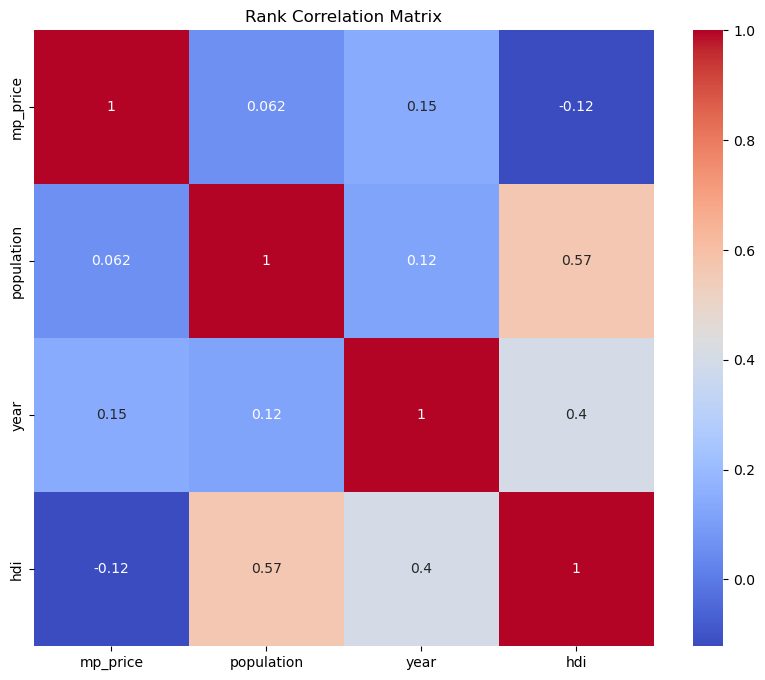

In [31]:
# Calculate rank correlation between variables
correlation_matrix = combined_df.corr(method='spearman')

# Display the correlation matrix
print("Rank Correlation Matrix:")
print(correlation_matrix)

# Plot the correlation matrix
plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm')
plt.title("Rank Correlation Matrix")
plt.show()

In [32]:
#modeling

In [33]:
#k-fold validation on linear regression

def kfold_linear_regression():
    
    #drop rows with missing values
    combined_df.dropna(inplace = True)

    #extract independent variables
    #convert string value a one-hot encoding
    X = pd.get_dummies(combined_df['countries'])
    X['mp_price'] = combined_df['mp_price']
    X['population'] = combined_df['population']
    X['year'] = combined_df['year']
    
    #dependent variable
    y = combined_df['hdi']
    
    #create a linear regression model
    model = LinearRegression()
    
    num_folds = 5
    kfold = KFold(n_splits = num_folds, shuffle = True, random_state = 69)
    
    r2_scores = []
    rmse_scores = []
    adj_r2_scores = []
    
    for train_index, test_index in kfold.split(X):
        X_train, X_test = X.iloc[train_index], X.iloc[test_index]
        y_train, y_test = y.iloc[train_index], y.iloc[test_index]
        
        model.fit(X_train, y_train)
        
        y_pred = model.predict(X_test)
        
        #rsquare
        r2 = r2_score(y_test, y_pred)
        r2_scores.append(r2)
        
        #RMSE
        rmse = np.sqrt(mean_squared_error(y_test, y_pred))
        rmse_scores.append(rmse)
        
        #adjusted r-square
        n = X_train.shape[0]  #number of samples in training set
        p = X_train.shape[1]  #number of features
        adj_r2 = 1 - ((1 - r2) * (n - 1)) / (n - p - 1)
        adj_r2_scores.append(adj_r2)
        
    avg_r2 = np.mean(r2_scores)
    avg_rmse = np.mean(rmse_scores)
    avg_adjr2 = np.mean(adj_r2_scores)
    
    print("for linear regression")
    print("r2 score: ", avg_r2)
    print("rmse score: ", avg_rmse)
    print("adjusted r2 score:", avg_adjr2)

kfold_linear_regression()
#r-squared, rmse, adjusted r-squared

for linear regression
r2 score:  0.9942453667138789
rmse score:  0.008042116597154255
adjusted r2 score: 0.9929245330999471


In [34]:
#polynomial regression
def kfold_polynomial_regression():
    
    #extract independent variables
    #convert string value a one-hot encoding
    X = pd.get_dummies(combined_df['countries'])
    X['mp_price'] = combined_df['mp_price']
    X['population'] = combined_df['population']
    X['year'] = combined_df['year']

    #dependent variable
    y = combined_df['hdi']

    num_folds = 5

    #loop through degrees 2 to 6
    for degrees in range(2, 7):
        print(f"Polynomial Regression (Degree {degrees}):")

        r2_scores = []
        rmse_scores = []
        adj_r2_scores = []

        kfold = KFold(n_splits = num_folds, shuffle = True, random_state = 69)

        for train_index, test_index in kfold.split(X):
            X_train, X_test = X.iloc[train_index], X.iloc[test_index]
            y_train, y_test = y.iloc[train_index], y.iloc[test_index]

            #apply polynomial feature transformation
            polynomial_features = PolynomialFeatures(degree = degrees)
            X_train_poly = polynomial_features.fit_transform(X_train)
            X_test_poly = polynomial_features.transform(X_test)

            #fit the polynomial regression model
            model = LinearRegression()
            model.fit(X_train_poly, y_train)

            #make predictions
            y_pred = model.predict(X_test_poly)

            #r2 score
            r2 = r2_score(y_test, y_pred)
            r2_scores.append(r2)

            #rmse score
            rmse = np.sqrt(mean_squared_error(y_test, y_pred))
            rmse_scores.append(rmse)

            #adjusted r-square
            n = X_train_poly.shape[0]
            p = X_train_poly.shape[1] - 1
            adj_r2 = 1 - ((1 - r2) * (n - 1)) / (n - p - 1)
            adj_r2_scores.append(adj_r2)

        avg_r2 = np.mean(r2_scores)
        avg_rmse = np.mean(rmse_scores)
        avg_adjr2 = np.mean(adj_r2_scores)

        print("R-squared:", avg_r2)
        print("RMSE:", avg_rmse)
        print("Adjusted R-squared:", avg_adjr2)
        print()
        
kfold_polynomial_regression()

Polynomial Regression (Degree 2):
R-squared: 0.9929295565673861
RMSE: 0.008792870820064578
Adjusted R-squared: 1.0330984841274797

Polynomial Regression (Degree 3):
R-squared: 0.9701993847502891
RMSE: 0.018400658723557405
Adjusted R-squared: 1.0068899079218254

Polynomial Regression (Degree 4):
R-squared: 0.9213891525557711
RMSE: 0.02824622432878941
Adjusted R-squared: 1.0044543141457842

Polynomial Regression (Degree 5):
R-squared: 0.8977071442450149
RMSE: 0.033276801517296936
Adjusted R-squared: 1.0018565024088417

Polynomial Regression (Degree 6):
R-squared: 0.1952178774593139
RMSE: 0.09826439555270682
Adjusted R-squared: 1.0054244388130507



In [35]:
#decision tree regression
def kfold_decision_tree_regression(max_depths):
    
    #extract independent variables
    #convert string value a one-hot encoding
    X = pd.get_dummies(combined_df['countries'])
    X['mp_price'] = combined_df['mp_price']
    X['population'] = combined_df['population']
    X['year'] = combined_df['year']

    #dependent variable
    y = combined_df['hdi']

    #create a decision tree regression model
    model = DecisionTreeRegressor(max_depth = max_depths)

    num_folds = 5
    kfold = KFold(n_splits = num_folds, shuffle = True, random_state = 69)

    r2_scores = []
    rmse_scores = []
    adj_r2_scores = []

    for train_index, test_index in kfold.split(X):
        X_train, X_test = X.iloc[train_index], X.iloc[test_index]
        y_train, y_test = y.iloc[train_index], y.iloc[test_index]

        model.fit(X_train, y_train)

        y_pred = model.predict(X_test)

        #r2 score
        r2 = r2_score(y_test, y_pred)
        r2_scores.append(r2)

        #RMSE
        rmse = np.sqrt(mean_squared_error(y_test, y_pred))
        rmse_scores.append(rmse)

        #adjusted r-squared
        n = X_train.shape[0]
        p = X_train.shape[1]
        adj_r2 = 1 - ((1 - r2) * (n - 1)) / (n - p - 1)
        adj_r2_scores.append(adj_r2)

    avg_r2 = np.mean(r2_scores)
    avg_rmse = np.mean(rmse_scores)
    avg_adjr2 = np.mean(adj_r2_scores)

    print(f"For Decision Tree Regression with degree {max_depths}:")
    print(f"R-squared: {avg_r2}")
    print(f"RMSE: {avg_rmse}")
    print(f"Adjusted R-squared: {avg_adjr2}")
    print()


#loop for different max-depth for decesion trees
for max_depths in range(2, 7):
    kfold_decision_tree_regression(max_depths)

For Decision Tree Regression with degree 2:
R-squared: 0.6456862764930236
RMSE: 0.06050270064157043
Adjusted R-squared: 0.5644900809393874

For Decision Tree Regression with degree 3:
R-squared: 0.9579550060215638
RMSE: 0.022208041744488705
Adjusted R-squared: 0.9482812099460849

For Decision Tree Regression with degree 4:
R-squared: 0.9746750726512861
RMSE: 0.017497350883308612
Adjusted R-squared: 0.9688349430572085

For Decision Tree Regression with degree 5:
R-squared: 0.9830885596696181
RMSE: 0.014511830344225398
Adjusted R-squared: 0.9791917711202928

For Decision Tree Regression with degree 6:
R-squared: 0.8334001698443917
RMSE: 0.02786090470804118
Adjusted R-squared: 0.7954947976647201



In [36]:
#random forest regression

def kfold_random_forest_regression(maxdepth):
    
    #extract independent variables
    #convert string value a one-hot encoding
    X = pd.get_dummies(combined_df['countries'])
    X['mp_price'] = combined_df['mp_price']
    X['population'] = combined_df['population']
    X['year'] = combined_df['year']

    #dependent variable
    y = combined_df['hdi']
    
    #create a random forest regression model
    model = RandomForestRegressor(max_depth = maxdepth)

    num_folds = 5
    kfold = KFold(n_splits = num_folds, shuffle = True, random_state = 69)

    r2_scores = []
    rmse_scores = []
    adj_r2_scores = []

    for train_index, test_index in kfold.split(X):
        X_train, X_test = X.iloc[train_index], X.iloc[test_index]
        y_train, y_test = y.iloc[train_index], y.iloc[test_index]

        model.fit(X_train, y_train)

        y_pred = model.predict(X_test)

        #r2
        r2 = r2_score(y_test, y_pred)
        r2_scores.append(r2)

        #RMSE
        rmse = np.sqrt(mean_squared_error(y_test, y_pred))
        rmse_scores.append(rmse)

        #adjusted r-squared
        n = X_train.shape[0]
        p = X_train.shape[1]
        adj_r2 = 1 - ((1 - r2) * (n - 1)) / (n - p - 1)
        adj_r2_scores.append(adj_r2)

    avg_r2 = np.mean(r2_scores)
    avg_rmse = np.mean(rmse_scores)
    avg_adjr2 = np.mean(adj_r2_scores)

    print(f"For Random Forest Regression with max_depth={max_depth}:")
    print(f"R-squared: {avg_r2}")
    print(f"RMSE: {avg_rmse}")
    print(f"Adjusted R-squared: {avg_adjr2}")
    print()


#loop for different tree depths
for max_depth in range(2, 12):
    kfold_random_forest_regression(max_depth)

For Random Forest Regression with max_depth=2:
R-squared: 0.7960187852310338
RMSE: 0.04917909094856322
Adjusted R-squared: 0.7491779191279614

For Random Forest Regression with max_depth=3:
R-squared: 0.9112740094795629
RMSE: 0.02965733884265276
Adjusted R-squared: 0.8909634375298859

For Random Forest Regression with max_depth=4:
R-squared: 0.9480719278588312
RMSE: 0.022600405154221716
Adjusted R-squared: 0.9361803419528811

For Random Forest Regression with max_depth=5:
R-squared: 0.9624934784251007
RMSE: 0.018267924822735926
Adjusted R-squared: 0.9539127206377431

For Random Forest Regression with max_depth=6:
R-squared: 0.9640221974682831
RMSE: 0.0173478135601024
Adjusted R-squared: 0.9557980112208881

For Random Forest Regression with max_depth=7:
R-squared: 0.9689218304162832
RMSE: 0.016625289211923494
Adjusted R-squared: 0.961815074249567

For Random Forest Regression with max_depth=8:
R-squared: 0.9638076420787064
RMSE: 0.017915483985009223
Adjusted R-squared: 0.955534690323095

In [37]:

# #support vector regression
# def support_vector_regression(kernel):
#     #independent variables
#     X = combined_df[['mp_price', 'population', 'year']]

#     #dependent variable
#     y = combined_df['hdi']
#     #create an SVR model with the specified kernel
#     model = SVR(kernel = kernel)

#     num_folds = 5
#     kfold = KFold(n_splits = num_folds, shuffle = True, random_state = 69)

#     r2_scores = []
#     rmse_scores = []
#     adj_r2_scores = []

#     for train_index, test_index in kfold.split(X):
#         X_train, X_test = X.iloc[train_index], X.iloc[test_index]
#         y_train, y_test = y.iloc[train_index], y.iloc[test_index]

#         model.fit(X_train, y_train)

#         y_pred = model.predict(X_test)

#         #r2
#         r2 = r2_score(y_test, y_pred)
#         r2_scores.append(r2)

#         #RMSE
#         rmse = np.sqrt(mean_squared_error(y_test, y_pred))
#         rmse_scores.append(rmse)

#         #adjusted r-squared
#         n = X_train.shape[0]  #number of samples in training set
#         p = X_train.shape[1]  #number of features
#         adj_r2 = 1 - ((1 - r2) * (n - 1)) / (n - p - 1)
#         adj_r2_scores.append(adj_r2)

#     avg_r2 = np.mean(r2_scores)
#     avg_rmse = np.mean(rmse_scores)
#     avg_adjr2 = np.mean(adj_r2_scores)

#     print(f"For Support Vector Regression with kernel='{kernel}':")
#     print(f"R-squared: {avg_r2}")
#     print(f"RMSE: {avg_rmse}")
#     print(f"Adjusted R-squared: {avg_adjr2}")


# #list of kernels to try
# kernels = ['linear', 'poly', 'rbf', 'sigmoid']

# #loop for different kernels
# for kernel in kernels:
#     support_vector_regression(kernel)

For Linear Regression:
R2 Score: 0.9974406543803088
RMSE Score: 0.006240482005785456
Adjusted R2 Score: 0.9969916463768542


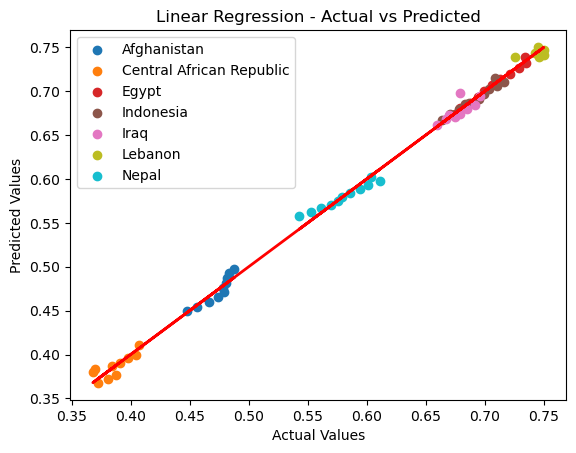

In [38]:
import matplotlib.pyplot as plt

def linear_regression():
    
    #drop rows with missing values
    combined_df.dropna(inplace=True)

    #extract independent variables
    #convert string value to one-hot encoding
    X = pd.get_dummies(combined_df['countries'])
    X['mp_price'] = combined_df['mp_price']
    X['population'] = combined_df['population']
    X['year'] = combined_df['year']
    
    #dependent variable
    y = combined_df['hdi']
    
    #create a linear regression model
    model = LinearRegression()
    
    #fit the model on the entire dataset
    model.fit(X, y)
    
    #predict the target variable
    y_pred = model.predict(X)
    
    #rsquare
    r2 = r2_score(y, y_pred)
    
    #RMSE
    rmse = np.sqrt(mean_squared_error(y, y_pred))
    
    #adjusted r-square
    n = X.shape[0]  # number of samples
    p = X.shape[1]  # number of features
    adj_r2 = 1 - ((1 - r2) * (n - 1)) / (n - p - 1)
    
    print("For Linear Regression:")
    print("R2 Score:", r2)
    print("RMSE Score:", rmse)
    print("Adjusted R2 Score:", adj_r2)

    #visualize the results
    countries = combined_df['countries'].unique()
    colormap = plt.cm.get_cmap('tab10', len(countries))

    #plot each country's data with a unique color
    for i, country in enumerate(countries):
        indices = combined_df['countries'] == country
        plt.scatter(y[indices], y_pred[indices], color = colormap(i), label = country)

    plt.plot(y, y, color = 'red', linewidth = 2)
    plt.xlabel('Actual Values')
    plt.ylabel('Predicted Values')
    plt.title('Linear Regression - Actual vs Predicted')
    plt.legend()
    plt.show()

linear_regression()

Polynomial Regression (Degree 2):
R-squared: 0.9985318068213646
RMSE: 0.004726561000995949
Adjusted R-squared: 0.9508155285157125


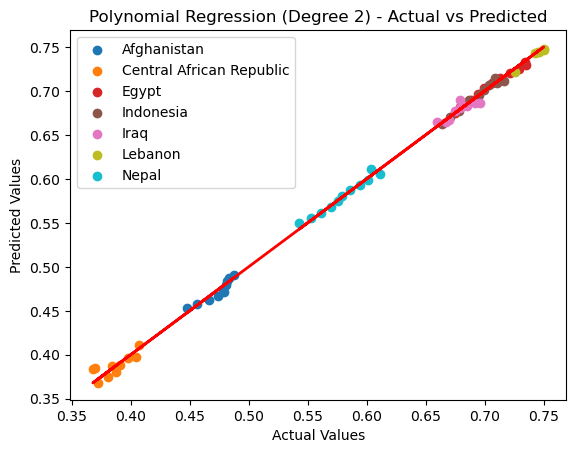

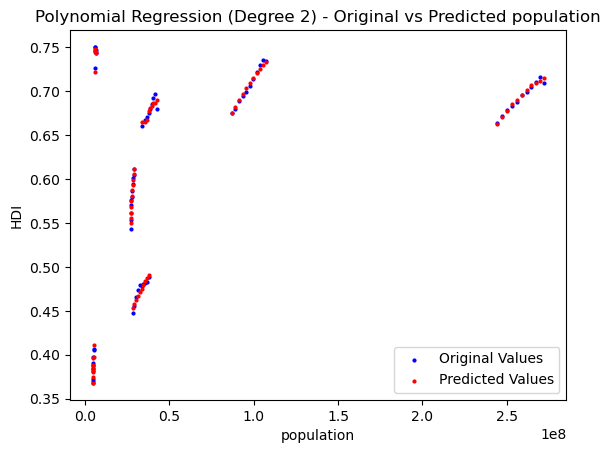

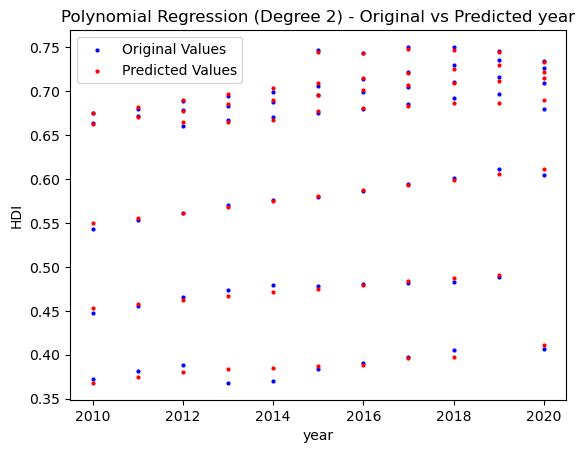

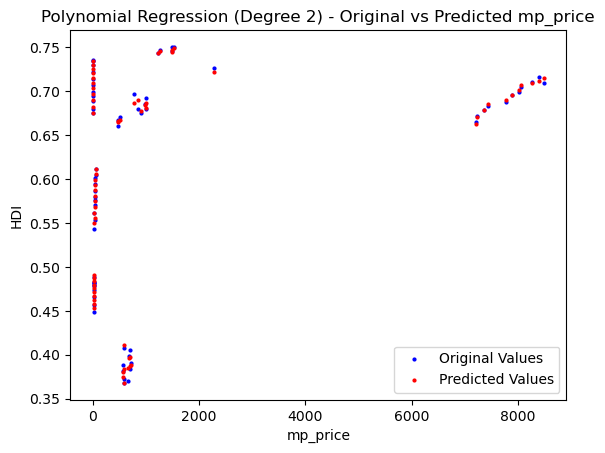

In [54]:
def polynomial_regression():
    #extract independent variables
    #convert string value to one-hot encoding
    X = pd.get_dummies(combined_df['countries'])
    X['mp_price'] = combined_df['mp_price']
    X['population'] = combined_df['population']
    X['year'] = combined_df['year']

    #dependent variable
    y = combined_df['hdi']

    #apply polynomial feature transformation
    polynomial_features = PolynomialFeatures(degree = 2)
    X_poly = polynomial_features.fit_transform(X)

    #fit the polynomial regression model
    model = LinearRegression()
    model.fit(X_poly, y)

    #make predictions
    y_pred = model.predict(X_poly)

    #r2
    r2 = r2_score(y, y_pred)

    #RMSE
    rmse = np.sqrt(mean_squared_error(y, y_pred))

    #adjusted R2
    n = X_poly.shape[0]
    p = X_poly.shape[1] - 1
    adj_r2 = 1 - ((1 - r2) * (n - 1)) / (n - p - 1)

    print("Polynomial Regression (Degree 2):")
    print("R-squared:", r2)
    print("RMSE:", rmse)
    print("Adjusted R-squared:", adj_r2)

    #visualize the results
    countries = combined_df['countries'].unique()
    colormap = plt.cm.get_cmap('tab10', len(countries))

    #plot each country's data with a unique color
    for i, country in enumerate(countries):
        indices = combined_df['countries'] == country
        plt.scatter(y[indices], y_pred[indices], color = colormap(i), label = country)

    plt.plot(y, y, color = 'red', linewidth = 2)
    plt.xlabel('Actual Values')
    plt.ylabel('Predicted Values')
    plt.title('Polynomial Regression (Degree 2) - Actual vs Predicted')
    plt.legend()
    plt.show()
    
    #visualize the results for Population vs HDI
    xvalues = ['population', 'year', 'mp_price']
    for i in xvalues:
        plt.scatter(X[i], y, color='blue', label='Original Values', s=4)  #set s to adjust dot size
        plt.scatter(X[i], y_pred, color='red', label='Predicted Values', s=4)  #set s to adjust dot size
        plt.xlabel(i)
        plt.ylabel('HDI')
        plt.title('Polynomial Regression (Degree 2) - Original vs Predicted ' + i)
        plt.legend()
        plt.show()

polynomial_regression()

For Decision Tree Regression with max depth 5:
R-squared: 0.9925012350668176
RMSE: 0.010681900694678831
Adjusted R-squared: 0.9911856622715225



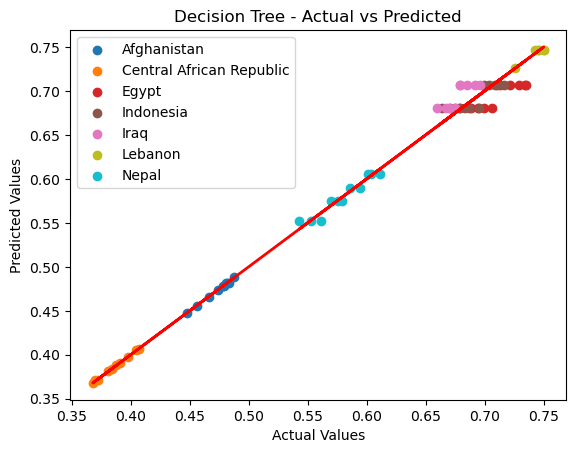

In [55]:
#decision tree regression
def decision_tree_regression(max_depth):
    # Extract independent variables and convert string values to one-hot encoding
    X = pd.get_dummies(combined_df['countries'])
    X['mp_price'] = combined_df['mp_price']
    X['population'] = combined_df['population']
    X['year'] = combined_df['year']

    #dependent variable
    y = combined_df['hdi']

    #create a decision tree regression model
    model = DecisionTreeRegressor(max_depth = max_depth)
    model.fit(X, y)

    #predict using the trained model
    y_pred = model.predict(X)

    #calculate evaluation metrics
    r2 = r2_score(y, y_pred)
    rmse = np.sqrt(mean_squared_error(y, y_pred))
    n = X.shape[0]
    p = X.shape[1]
    adj_r2 = 1 - ((1 - r2) * (n - 1)) / (n - p - 1)

    #print the results
    print(f"For Decision Tree Regression with max depth {max_depth}:")
    print(f"R-squared: {r2}")
    print(f"RMSE: {rmse}")
    print(f"Adjusted R-squared: {adj_r2}")
    print()
    
    #visualize the results
    countries = combined_df['countries'].unique()

    colormap = plt.cm.get_cmap('tab10', len(countries))

    #plot each country's data with a unique color
    for i, country in enumerate(countries):
        indices = combined_df['countries'] == country
        plt.scatter(y[indices], y_pred[indices], color = colormap(i), label = country)

    plt.plot(y, y, color = 'red', linewidth = 2)
    plt.xlabel('Actual Values')
    plt.ylabel('Predicted Values')
    plt.title('Decision Tree - Actual vs Predicted')
    plt.legend()
    plt.show()
    
decision_tree_regression(5)

For Random Forest Regression with max depth 7:
R-squared: 0.9984587115229365
RMSE: 0.004842789945502335
Adjusted R-squared: 0.9981883100357324



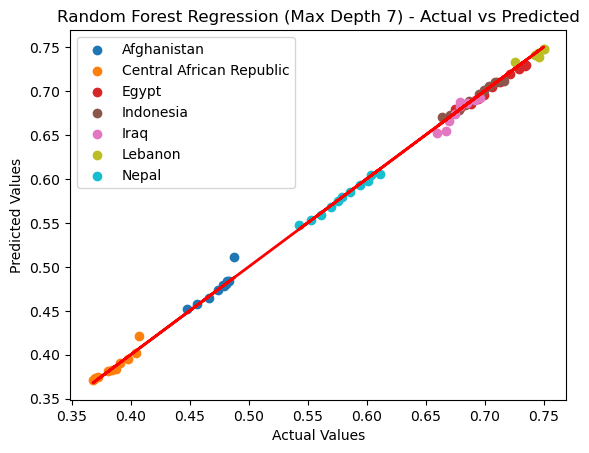

In [56]:
def random_forest_regression(max_depth):
    #extract independent variables and convert string values to one-hot encoding
    X = pd.get_dummies(combined_df['countries'])
    X['mp_price'] = combined_df['mp_price']
    X['population'] = combined_df['population']
    X['year'] = combined_df['year']

    #dependent variable
    y = combined_df['hdi']

    #create a random forest regression model
    model = RandomForestRegressor(max_depth = max_depth)
    model.fit(X, y)

    #predict using the trained model
    y_pred = model.predict(X)

    #calculate evaluation metrics
    r2 = r2_score(y, y_pred)
    rmse = np.sqrt(mean_squared_error(y, y_pred))
    n = X.shape[0]
    p = X.shape[1]
    adj_r2 = 1 - ((1 - r2) * (n - 1)) / (n - p - 1)

    #print the results
    print(f"For Random Forest Regression with max depth {max_depth}:")
    print(f"R-squared: {r2}")
    print(f"RMSE: {rmse}")
    print(f"Adjusted R-squared: {adj_r2}")
    print()

    #visualize the results
    countries = combined_df['countries'].unique()

    colormap = plt.cm.get_cmap('tab10', len(countries))

    #plot each country's data with a unique color
    for i, country in enumerate(countries):
        indices = combined_df['countries'] == country
        plt.scatter(y[indices], y_pred[indices], color = colormap(i), label = country)

    plt.plot(y, y, color = 'red', linewidth = 2)
    plt.xlabel('Actual Values')
    plt.ylabel('Predicted Values')
    plt.title(f"Random Forest Regression (Max Depth {max_depth}) - Actual vs Predicted")
    plt.legend()
    plt.show()

random_forest_regression(7)